<a href="https://colab.research.google.com/github/kanish-dev/neural-nets-learnings/blob/main/microgradmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import random

### ***HEART***

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
 
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


### **DRAW DOT**

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes,edges=set(),set()

  def build(v):
    if v not in  nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges


def draw_dot(root):
  dot=Digraph(format="svg",graph_attr={'rankdir':'LR'})

  nodes,edges=trace(root)
  for n in nodes:
    uid=str(id(n))
    dot.node(name=uid,label="{%s| Data %.4f |Grad %.4f}" % (n.label, n.data,n.grad,),shape="record")

    if n._op:
      dot.node(name=uid+n._op,label=n._op)

      dot.edge(uid + n._op, uid)

  for n1,n2 in edges:
     dot.edge(str(id(n1)),str(id(n2))+n2._op)

  return dot



### TESTING-**1** Micrograd

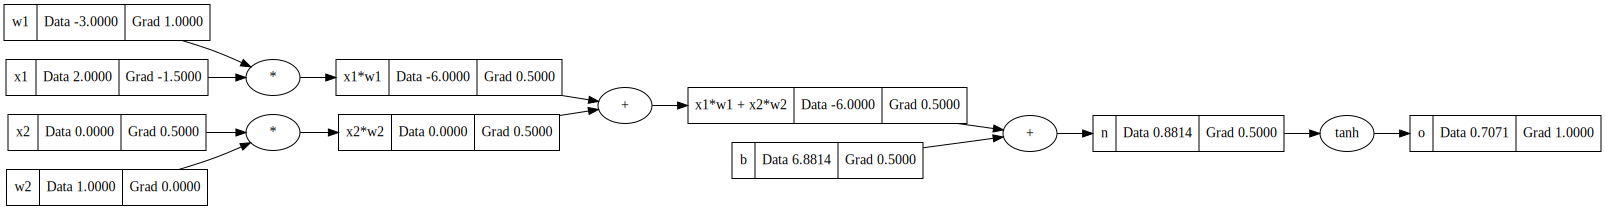

In [ ]:
#inputs x1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#Weights w1,w2
w1=Value(-3.0, label = 'w1')
w2=Value(1.0, label = 'w2')

#bias of the neuron
b=Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1=x1*w1; x1w1.label = 'x1*w1'
x2w2=x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2=x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n=x1w1x2w2 + b; n.label = 'n'

o=n.tanh(); o.label='o'
o.backward()
draw_dot(o)

### **TESTING-2 Micrograd**

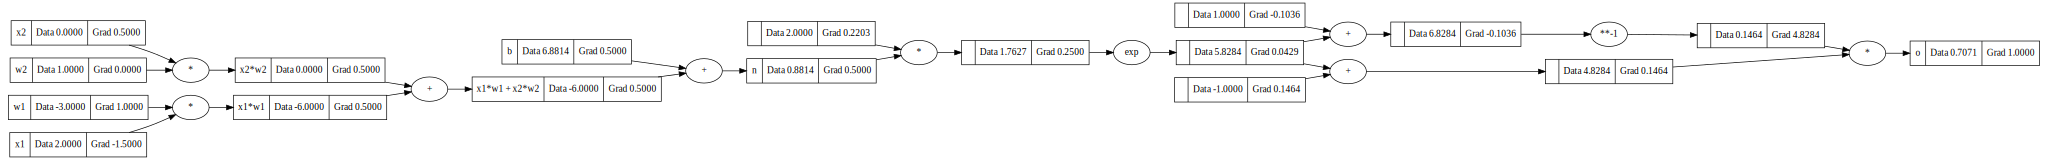

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

### **Implementing the same using the pytorch and verfying the answers**

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad = True
b = torch.Tensor([6.881373587019543]).double() ; b.requires_grad = True

n=x1 * w1 + x2 * w2 + b

o=torch.tanh(n)

print(o.data.item())
o.backward()
print('-------------------')
print("x2",x2.grad.item())
print("w2",w2.grad.item())
print("x1",x1.grad.item())
print("w1",w1.grad.item())

0.7071066904050358
-------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### **BUILDING A NEURAL NET LIBRARY (MULTI-LAYER PERCEPTRON) IN MICROGRAD**

In [ ]:
class Neuron:
  def __init__(self,nin):                                         #nin= no of inputs to neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]    #weight of the neuron
    self.b = Value(random.uniform(-1,1))                          #bias  that triggers the over all happiness of the neuron
 
  def __call__(self,x):
    # x * w + b
    # print(list(zip(self.w,x)),self.b)
    act = sum((xi*wi for xi,wi in zip(self.w,x)),self.b)          # first zip the (x,w) then iterate over the zip and multiply the w and x of each tuple  and totlally sum all up!!
    out = act.tanh()                                              # passing throungh non-linearity
    return out
    # return 0.0
  def parameters(self):
    return self.w + [self.b]
  
class Layer:
  def __init__(self, nin, nout):                                  # nouts = size of layer
    self.neurons= [Neuron(nin) for _ in range(nout)]              #create no of neurons in the layer

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]                           #return the no layers in the neuron
    
    return outs[0] if len(outs)==1 else outs
  
  def parameters(self):
  
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # or
    # params=[]
    # for neuron in self.neurons:
    #   ps = neuron.parameters( ) 
    #   params.extend(ps)             # a type of append
    # return params

 

class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [ ]:
x = [2.0, 3.0, -1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.32207535993485)

In [ ]:
n.parameters()

[Value(data=0.061086278185462195),
 Value(data=-0.23365654273906888),
 Value(data=-0.33988548735023305),
 Value(data=0.6039246029395422),
 Value(data=0.38491960572633355),
 Value(data=0.4423471484583106),
 Value(data=-0.9751893914563081),
 Value(data=-0.9541202738698031),
 Value(data=-0.10371724274066807),
 Value(data=-0.5199968209448238),
 Value(data=-0.27741890279402703),
 Value(data=-0.0222245052724519),
 Value(data=-0.1692404517950279),
 Value(data=0.8558278147942537),
 Value(data=-0.7877979084906865),
 Value(data=-0.30781810306307067),
 Value(data=0.7159089845047042),
 Value(data=0.9377202177983179),
 Value(data=0.9403377794868493),
 Value(data=0.7574788298721442),
 Value(data=0.6037783288629659),
 Value(data=0.05331217874211314),
 Value(data=-0.6796851950860083),
 Value(data=-0.5272848063037676),
 Value(data=0.5335928116176214),
 Value(data=0.14407966701755548),
 Value(data=0.3841079515928443),
 Value(data=-0.08183646404706435),
 Value(data=-0.17859457787719157),
 Value(data=-0.9

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### **GRADIENT DESCENT OPTIMIZATION**

In [ ]:
for k in range(20):
  #forward pass
  ypred=[n(x) for x in xs]  
  loss = sum([(yp-ys)**2 for ys,yp in zip(ys, ypred)])

  #backward pass
  for p in n.parameters():
    p.grad=0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.1*p.grad

  print("Loss: ",k,"=>", loss.data)



Loss:  0 => 0.013531098010839928
Loss:  1 => 0.012939205887001341
Loss:  2 => 0.012395651138086602
Loss:  3 => 0.011894765135120553
Loss:  4 => 0.011431734251222571
Loss:  5 => 0.011002443850071278
Loss:  6 => 0.010603355393175008
Loss:  7 => 0.010231408705407268
Loss:  8 => 0.009883943562073852
Loss:  9 => 0.00955863626516007
Loss:  10 => 0.009253447956512437
Loss:  11 => 0.008966582200915953
Loss:  12 => 0.008696449949458741
Loss:  13 => 0.008441640422777487
Loss:  14 => 0.008200896775982108
Loss:  15 => 0.007973095651197902
Loss:  16 => 0.0077572299102583574
Loss:  17 => 0.0075523939838627015
Loss:  18 => 0.007357771385148648
Loss:  19 => 0.007172624022936346


In [ ]:
ypred

[Value(data=0.9351235683254807),
 Value(data=-0.9467848272107862),
 Value(data=-0.94884841175438),
 Value(data=0.9327634006482014)]

In [ ]:
ypred

[Value(data=0.9556194357915101),
 Value(data=-0.9612241235843365),
 Value(data=-0.9611340194715848),
 Value(data=0.953214783219114)]

visualizing thne neural network


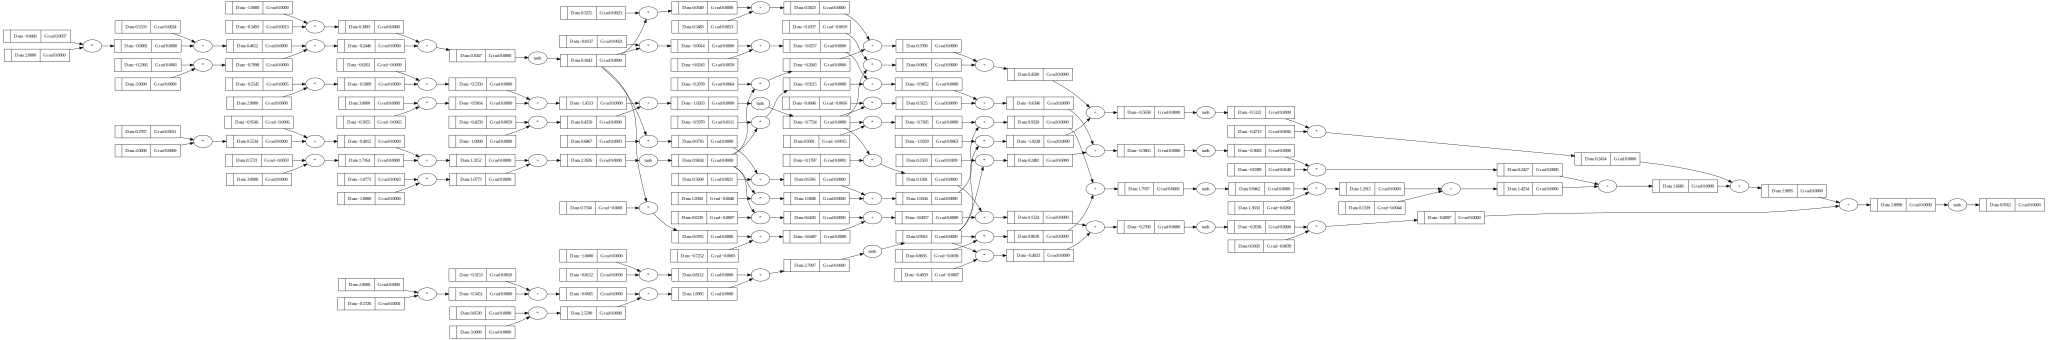

In [ ]:
print("visualizing thne neural network")
draw_dot(n(x))

visualizing the loss of neural network


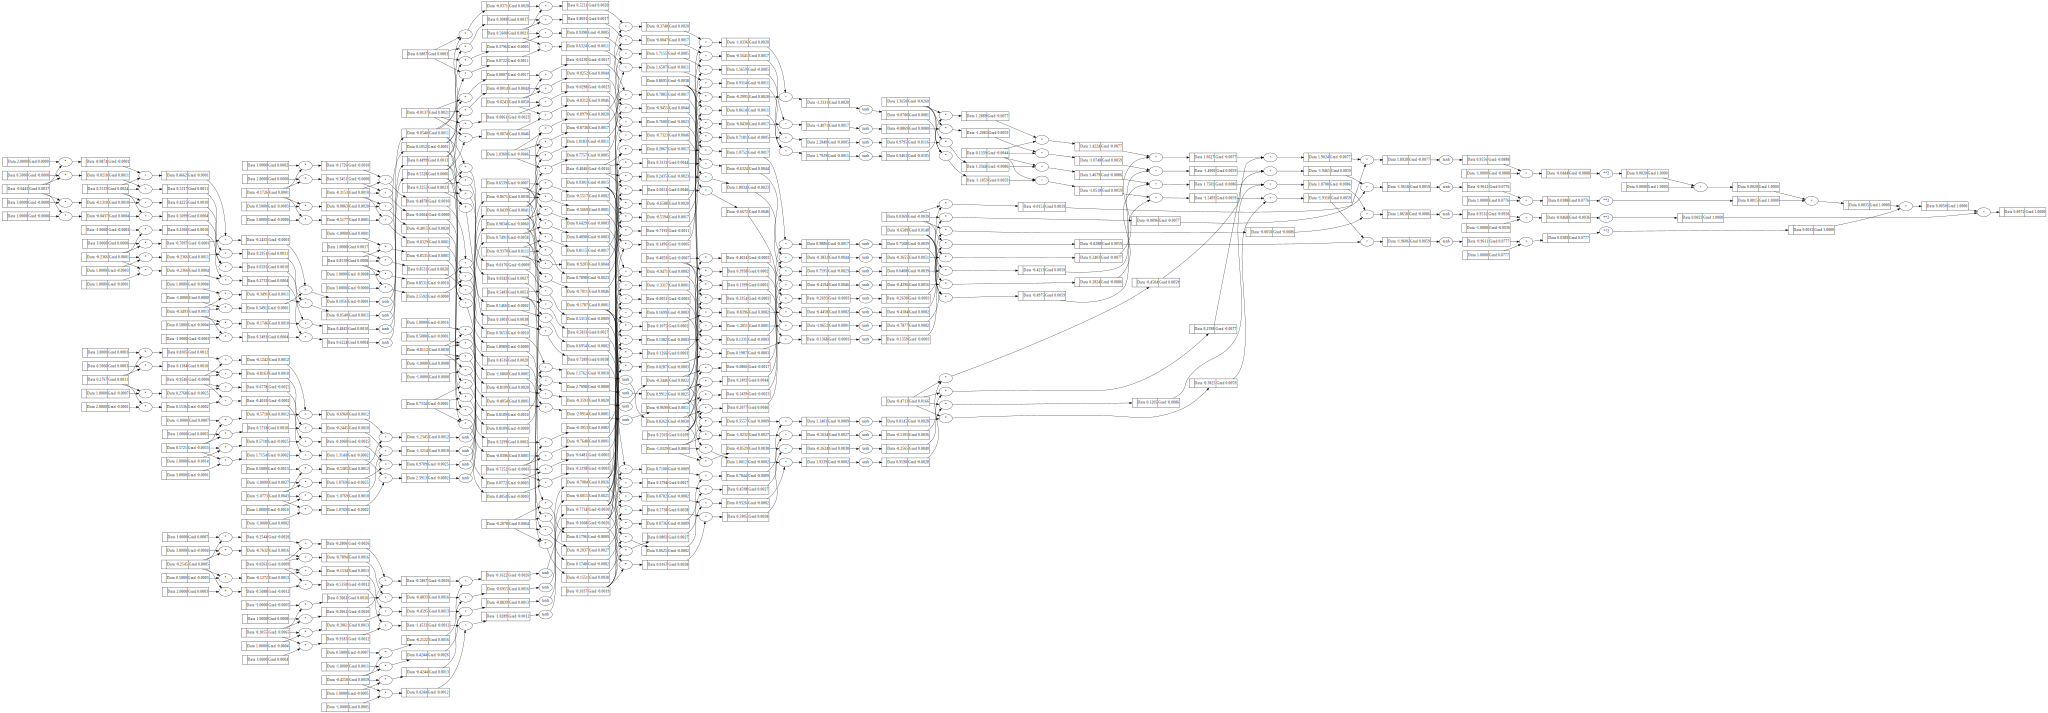

In [ ]:
print("visualizing the loss of neural network")
draw_dot(loss)